## About exp
- March Mania 2021
- W

## Library

In [1]:
# library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

from gensim.models import word2vec, KeyedVectors
import pycld2 as cld2

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout,Concatenate,Lambda,GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

/Users/kazuki/.pyenv/versions/anaconda3-2020.02/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## Config

In [2]:
# Config
SEED = 1010
SHUFFLE = True
N_SPLITS = 5
TRAIN = True

EXP = '003'

LGBM_PARAMS = {
    'num_leaves': 300,
    'max_bin':450,
    'objective': 'binary',
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'metric':"binary_logloss",
}

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

# SEED
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

## Function

In [3]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        #feature_name=feature_name
                        )

    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            #feature_name=feature_name
                            )

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

In [4]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FGRatioW':'FGRatioA',
        'FG3RatioW':'FG3RatioA',
        'FTRatioW':'FTRatioA',
        'eFGW':'eFGA',
        'TO%W':'TO%A',
        'FTRW':'FTRA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLossesW':'NumLossesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FGRatioL':'FGRatioB',
        'FG3RatioL':'FG3RatioB',
        'FTRatioL':'FTRatioB',
        'eFGL':'eFGB',
        'TO%L':'TO%B',
        'FTRL':'FTRB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLossesL':'NumLossesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FGRatioW':'FGRatioB',
        'FG3RatioW':'FG3RatioB',
        'FTRatioW':'FTRatioB',
        'eFGW':'eFGB',
        'TO%W':'TO%B',
        'FTRW':'FTRB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLossesW':'NumLossesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FGRatioL':'FGRatioA',
        'FG3RatioL':'FG3RatioA',
        'FTRatioL':'FTRatioA',
        'eFGL':'eFGA',
        'TO%L':'TO%A',
        'FTRL':'FTRA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLossesL':'NumLossesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [5]:
# Loss
def calc_loss(y_true, y_pred):
    return  log_loss(y_true, y_pred)

In [6]:
# NN
def create_mlp(input_dim, output_dim, learning_rate):

    inputs = Input(input_dim)
    
    x = BatchNormalization()(inputs)
    
    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    out = Dense(output_dim, activation='sigmoid')(x)
   
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss= BinaryCrossentropy(),
        metrics = tf.keras.metrics.AUC(name="AUC"),
    )

    return model

# Reading data

In [7]:
os.listdir('./ncaaw-march-mania-2021/WDataFiles_Stage2/')

['WNCAATourneySlots.csv',
 'WTeams.csv',
 'WSampleSubmissionStage2.csv',
 'WNCAATourneyDetailedResults.csv',
 'WNCAATourneyCompactResults.csv',
 'WSeasons.csv',
 'Cities.csv',
 'WRegularSeasonCompactResults.csv',
 'WTeamSpellings.csv',
 'WRegularSeasonDetailedResults.csv',
 'WNCAATourneySeeds.csv',
 'WTeamConferences.csv',
 'Conferences.csv',
 'WGameCities.csv']

In [8]:
datasets_path = './ncaaw-march-mania-2021/WDataFiles_Stage2/'
SAVE_TEST_SUB_PATH = f"exp{EXP}_submission_w.csv"
SUB_PATH = datasets_path + 'WSampleSubmissionStage2.csv'

In [9]:
regular_result = pd.read_csv(datasets_path + 'WRegularSeasonDetailedResults.csv')
regular_result

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60344,2021,131,3465,78,3213,60,N,0,24,61,17,40,13,16,15,29,17,18,2,5,21,19,62,4,24,18,24,12,20,10,10,8,2,14
60345,2021,132,3124,76,3452,50,N,0,33,66,3,8,7,10,9,34,15,16,5,8,15,17,63,3,16,13,14,8,22,4,14,5,7,17
60346,2021,132,3133,78,3179,70,N,0,28,64,12,26,10,11,7,21,17,6,4,4,16,27,61,4,19,12,15,11,25,17,12,4,2,14
60347,2021,132,3195,84,3251,62,N,0,26,52,14,32,18,26,5,21,22,10,10,3,17,20,53,7,20,15,15,8,22,9,18,7,2,20


## Preprocessing, FE

In [10]:
num_win = regular_result.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,2010,3102,1
1,2010,3103,17
2,2010,3104,11
3,2010,3105,14
4,2010,3106,12
...,...,...,...
4142,2021,3466,7
4143,2021,3467,5
4144,2021,3468,5
4145,2021,3470,5


In [11]:
num_loss = regular_result.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
num_loss

,Season,TeamID,NumLosses
0,2010,3102,27
1,2010,3103,13
2,2010,3104,18
3,2010,3105,13
4,2010,3106,17
...,...,...,...
4149,2021,3467,10
4150,2021,3468,17
4151,2021,3469,2
4152,2021,3470,16


In [12]:
wl = pd.merge(num_win, num_loss, how='left', on=['Season', 'TeamID']).reset_index(drop=True)
wl

,Season,TeamID,NumWins,NumLosses
0,2010,3102,1,27.0
1,2010,3103,17,13.0
2,2010,3104,11,18.0
3,2010,3105,14,13.0
4,2010,3106,12,17.0
...,...,...,...,...
4142,2021,3466,7,18.0
4143,2021,3467,5,10.0
4144,2021,3468,5,17.0
4145,2021,3470,5,16.0


In [13]:
wteam_stats = regular_result.groupby(['Season', 'WTeamID']).mean().reset_index()
wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
], axis=1, inplace=True)
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2010,3102,68.000000,48.000000,23.000000,51.000000,6.000000,14.000000,16.000000,21.000000,11.000000,29.000000,13.000000,14.000000,9.000000,1.000000,10.000000
1,2010,3103,66.352941,53.176471,23.941176,56.000000,4.352941,12.235294,14.117647,19.823529,14.176471,25.764706,14.235294,16.882353,8.705882,2.705882,16.058824
2,2010,3104,72.818182,57.454545,28.000000,59.545455,4.818182,13.636364,12.000000,19.636364,14.363636,28.000000,17.181818,20.545455,8.454545,3.000000,18.454545
3,2010,3105,66.428571,59.071429,21.785714,47.571429,3.142857,8.357143,19.714286,26.500000,11.285714,25.571429,11.285714,25.714286,8.928571,5.642857,18.714286
4,2010,3106,59.833333,51.333333,19.583333,49.833333,2.250000,7.000000,18.416667,28.166667,14.916667,25.583333,12.166667,19.250000,7.500000,5.333333,21.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,2021,3466,72.142857,61.714286,24.571429,57.000000,8.285714,25.571429,14.714286,20.428571,10.142857,25.857143,15.714286,16.571429,8.285714,3.142857,17.000000
4143,2021,3467,73.400000,64.400000,26.000000,58.800000,9.000000,22.200000,12.400000,17.200000,9.600000,26.200000,14.000000,17.800000,8.800000,1.200000,18.000000
4144,2021,3468,72.200000,66.400000,22.800000,58.800000,5.200000,15.200000,21.400000,28.400000,9.600000,22.800000,11.000000,15.000000,7.800000,2.200000,16.800000
4145,2021,3470,65.800000,53.000000,19.200000,48.800000,5.000000,18.200000,22.400000,29.600000,7.800000,25.200000,12.400000,14.000000,7.600000,2.800000,15.600000


In [14]:
lteam_stats = regular_result.groupby(['Season', 'LTeamID']).mean().reset_index()
lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
], axis=1, inplace=True)
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2010,3102,72.666667,51.222222,19.000000,53.222222,4.518519,16.148148,8.703704,12.925926,12.518519,19.185185,10.148148,17.851852,5.925926,0.629630,15.148148
1,2010,3103,68.076923,56.846154,20.000000,54.307692,3.384615,12.769231,13.461538,19.307692,14.230769,20.692308,12.384615,20.076923,7.153846,2.000000,19.461538
2,2010,3104,72.833333,58.833333,22.722222,63.666667,4.055556,15.388889,9.333333,15.055556,14.555556,24.666667,10.611111,18.333333,6.722222,2.888889,21.611111
3,2010,3105,70.846154,54.692308,18.846154,54.384615,2.923077,11.538462,14.076923,22.000000,16.230769,21.000000,8.076923,24.307692,8.615385,4.615385,19.615385
4,2010,3106,61.705882,51.823529,17.647059,55.235294,3.000000,11.411765,13.529412,21.058824,15.058824,24.176471,11.000000,20.705882,8.411765,3.882353,22.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4149,2021,3467,68.800000,60.300000,22.100000,59.200000,7.300000,22.700000,8.800000,12.400000,10.400000,24.000000,11.800000,16.400000,9.200000,2.100000,17.700000
4150,2021,3468,80.352941,60.000000,21.647059,60.941176,5.470588,19.294118,11.235294,15.470588,9.294118,19.882353,10.764706,15.882353,7.294118,2.176471,18.000000
4151,2021,3469,71.500000,48.500000,17.000000,55.500000,5.000000,18.500000,9.500000,16.000000,9.000000,24.500000,9.000000,17.500000,3.000000,4.500000,20.000000
4152,2021,3470,71.375000,56.312500,18.187500,56.062500,5.062500,20.250000,14.875000,21.250000,7.875000,20.875000,9.187500,14.437500,6.875000,2.625000,12.500000


In [15]:
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()

# Score-gab
regular_season_feature['Scoregap'] = regular_season_feature['Score'] -regular_season_feature['Scored']
# FGM/FGA
regular_season_feature['FGRatio'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# FGM3/FGA3
regular_season_feature['FG3Ratio'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FTM/FTA
regular_season_feature['FTRatio'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value)
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FGRatio']+regular_season_feature['FGM3']*regular_season_feature['FG3Ratio']+regular_season_feature['FTM']*regular_season_feature['FTRatio']
# TR
regular_season_feature['TR'] = regular_season_feature['OR']+regular_season_feature['DR']
# TS%
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA']))

# Four-Factor
regular_season_feature['eFG'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']

regular_season_feature['TO%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

regular_season_feature['FTR'] = regular_season_feature['FTA']/regular_season_feature['FGA']

# PPP/POSS
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] +regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Losses
regular_season_feature = regular_season_feature.merge(wl, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins']+regular_season_feature['NumLosses'])

#regular_season_feature.drop(['Score'], axis=1, inplace=True)
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Scoregap,FGRatio,FG3Ratio,FTRatio,EV,TR,TS%,eFG,OR%,TO%,FTR,POSS,PPP,NumWins,NumLosses,WinRatio
0,2010,3102,59.611111,60.333333,21.000000,52.111111,5.259259,15.074074,12.351852,16.962963,11.759259,24.092593,11.574074,15.925926,7.462963,0.814815,12.574074,-0.722222,0.402985,0.348894,0.728166,19.291810,35.851852,0.500305,0.453447,0.225657,0.210937,0.325515,75.500741,0.789543,1.0,27.0,0.035714
1,2010,3103,61.599548,60.626697,21.970588,55.153846,3.868778,12.502262,13.789593,19.565611,14.203620,23.228507,13.309955,18.479638,7.929864,2.352941,17.760181,0.972851,0.398351,0.309446,0.704787,19.667913,37.432127,0.483037,0.433424,0.257527,0.224697,0.354746,82.242353,0.749000,17.0,13.0,0.566667
2,2010,3104,65.825758,65.143939,25.361111,61.606061,4.436869,14.512626,10.666667,17.345960,14.459596,26.333333,13.896465,19.439394,7.588384,2.944444,20.032828,0.681818,0.411666,0.305725,0.614937,18.356088,40.792929,0.475357,0.447676,0.234711,0.219214,0.281563,88.677677,0.742304,11.0,18.0,0.379310
3,2010,3105,60.560440,64.958791,20.315934,50.978022,3.032967,9.947802,16.895604,24.250000,13.758242,23.285714,9.681319,25.010989,8.771978,5.129121,19.164835,-4.398352,0.398523,0.304888,0.696726,20.792697,37.043956,0.491179,0.428271,0.269886,0.288614,0.475695,86.659011,0.698836,14.0,13.0,0.518519
4,2010,3106,55.828431,56.519608,18.615196,52.534314,2.625000,9.205882,15.973039,24.612745,14.987745,24.879902,11.583333,19.977941,7.955882,4.607843,22.022059,-0.691176,0.354344,0.285144,0.648974,17.710769,39.867647,0.440538,0.379327,0.285294,0.239711,0.468508,83.341863,0.669873,12.0,17.0,0.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4158,2021,3467,66.850000,66.600000,24.050000,59.000000,8.150000,22.450000,10.600000,14.800000,10.000000,25.100000,12.900000,17.100000,9.000000,1.650000,17.850000,0.250000,0.407627,0.363029,0.716216,20.354010,35.100000,0.510212,0.476695,0.169492,0.206992,0.250847,82.612000,0.809204,5.0,10.0,0.333333
4159,2021,3468,66.100000,73.376471,22.223529,59.870588,5.335294,17.247059,16.317647,21.935294,9.447059,21.341176,10.882353,15.441176,7.547059,2.188235,17.400000,-7.276471,0.371193,0.309345,0.743899,22.038345,30.788235,0.475388,0.415750,0.157791,0.181739,0.366378,84.963294,0.777983,5.0,17.0,0.227273
4160,2021,3469,48.500000,71.500000,17.000000,55.500000,5.000000,18.500000,9.500000,16.000000,9.000000,24.500000,9.000000,17.500000,3.000000,4.500000,20.000000,-23.000000,0.306306,0.270270,0.593750,12.199184,33.500000,0.387752,0.351351,0.162162,0.218641,0.288288,80.040000,0.605947,NaN,NaN,NaN
4161,2021,3470,61.056250,62.187500,18.693750,52.431250,5.031250,19.225000,18.637500,25.425000,7.837500,23.037500,10.793750,14.218750,7.237500,2.712500,14.050000,-1.131250,0.356538,0.261704,0.733038,21.643736,30.875000,0.479864,0.404518,0.149481,0.182673,0.484921,77.837000,0.784412,5.0,16.0,0.238095


In [16]:
tourney_results = pd.read_csv(datasets_path + 'WNCAATourneyCompactResults.csv')
tourney_results = tourney_results[tourney_results['Season'] >= 2010].reset_index(drop=True)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2010,138,3124,69,3201,55,N,0
1,2010,138,3173,67,3395,66,N,0
2,2010,138,3181,72,3214,37,H,0
3,2010,138,3199,75,3256,61,H,0
4,2010,138,3207,62,3265,42,N,0
...,...,...,...,...,...,...,...,...
625,2019,147,3124,85,3234,53,N,0
626,2019,147,3323,84,3390,68,H,0
627,2019,151,3124,72,3332,67,N,0
628,2019,151,3323,81,3163,76,N,0


In [17]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsW', 'NumLosses':'NumLossesW', 'WinRatio': 'WinRatioW',
    'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW','OR':'ORW',
    'DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
    'FGRatio':'FGRatioW','FG3Ratio':'FG3RatioW','FTRatio':'FTRatioW','eFG':'eFGW','TO%':'TO%W','FTR':'FTRW',
    'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W','Score':'ScoreW',
    'Scored':'ScoredW','Scoregap':'ScoregapW'
}).drop(columns='TeamID', axis=1)

tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW
0,2010,138,3124,69,3201,55,N,0,67.432367,60.103865,24.340580,56.644928,2.359903,9.572464,16.391304,22.410628,11.826087,30.434783,13.463768,16.710145,6.301932,6.768116,14.391304,7.328502,0.429704,0.246530,0.731408,23.029769,42.260870,0.506968,0.450535,0.208776,0.200805,0.395633,83.215749,0.810332,23.0,9.0,0.718750
1,2010,138,3173,67,3395,66,N,0,67.047619,63.576190,24.709524,61.257143,4.828571,17.361905,12.800000,18.300000,14.376190,26.447619,12.457143,17.128571,7.680952,3.895238,17.195238,3.471429,0.403374,0.278113,0.699454,20.263067,40.823810,0.483685,0.442786,0.234686,0.198161,0.298741,86.437714,0.775676,21.0,5.0,0.807692
2,2010,138,3181,72,3214,37,H,0,66.137037,62.940741,24.544444,65.155556,4.496296,15.500000,12.551852,18.788889,18.974074,23.233333,12.274074,18.433333,12.081481,4.433333,18.874074,3.196296,0.376705,0.290084,0.668047,18.935546,42.207407,0.450386,0.411210,0.291212,0.200676,0.288370,91.856000,0.720008,27.0,5.0,0.843750
3,2010,138,3199,75,3256,61,H,0,68.040000,65.740000,24.400000,61.200000,5.340000,18.140000,13.900000,19.560000,15.760000,25.480000,14.160000,19.340000,8.180000,3.540000,17.800000,2.300000,0.398693,0.294377,0.710634,21.177890,41.240000,0.487348,0.442320,0.257516,0.216947,0.319608,89.146400,0.763239,25.0,5.0,0.833333
4,2010,138,3207,62,3265,42,N,0,64.020833,61.166667,22.520833,61.979167,5.708333,20.791667,13.270833,18.458333,16.979167,18.979167,14.791667,16.437500,12.479167,2.625000,19.395833,2.854167,0.363361,0.274549,0.718962,19.291638,35.958333,0.456634,0.409412,0.273950,0.189945,0.297815,86.538333,0.739797,24.0,6.0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,147,3124,85,3234,53,N,0,72.016129,61.048387,27.193548,63.564516,3.048387,7.693548,14.580645,19.870968,13.225806,31.822581,17.951613,14.016129,5.806452,6.580645,16.741935,10.967742,0.427810,0.396226,0.733766,23.540314,45.048387,0.497984,0.451789,0.208069,0.162367,0.312611,86.323871,0.834255,31.0,1.0,0.968750
626,2019,147,3323,84,3390,68,H,0,80.316667,71.066667,30.366667,63.750000,3.933333,13.050000,15.650000,21.366667,12.500000,28.416667,17.200000,14.050000,6.650000,5.316667,15.683333,9.250000,0.476340,0.301405,0.732449,27.113211,40.916667,0.548976,0.507190,0.196078,0.161121,0.335163,87.201333,0.921049,30.0,3.0,0.909091
627,2019,151,3124,72,3332,67,N,0,72.016129,61.048387,27.193548,63.564516,3.048387,7.693548,14.580645,19.870968,13.225806,31.822581,17.951613,14.016129,5.806452,6.580645,16.741935,10.967742,0.427810,0.396226,0.733766,23.540314,45.048387,0.497984,0.451789,0.208069,0.162367,0.312611,86.323871,0.834255,31.0,1.0,0.968750
628,2019,151,3323,81,3163,76,N,0,80.316667,71.066667,30.366667,63.750000,3.933333,13.050000,15.650000,21.366667,12.500000,28.416667,17.200000,14.050000,6.650000,5.316667,15.683333,9.250000,0.476340,0.301405,0.732449,27.113211,40.916667,0.548976,0.507190,0.196078,0.161121,0.335163,87.201333,0.921049,30.0,3.0,0.909091


In [18]:
tourney_results = tourney_results.merge(regular_season_feature,
left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsL', 'NumLosses':'NumLossesL', 'WinRatio': 'WinRatioL',
    'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
    'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
    'FGRatio':'FGRatioL','FG3Ratio':'FG3RatioL','FTRatio':'FTRatioL','eFG':'eFGL','TO%':'TO%L','FTR':'FTRL',
    'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
    'Scored':'ScoredL','Scoregap':'ScoregapL'
}).drop(columns='TeamID', axis=1)

tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,FGMW,FGAW,FGM3W,FGA3W,FTMW,FTAW,ORW,DRW,AstW,TOW,StlW,BlkW,PFW,ScoregapW,FGRatioW,FG3RatioW,FTRatioW,EVW,TRW,TS%W,eFGW,OR%W,TO%W,FTRW,POSSW,PPPW,NumWinsW,NumLossesW,WinRatioW,ScoreL,ScoredL,FGML,FGAL,FGM3L,FGA3L,FTML,FTAL,ORL,DRL,AstL,TOL,StlL,BlkL,PFL,ScoregapL,FGRatioL,FG3RatioL,FTRatioL,EVL,TRL,TS%L,eFGL,OR%L,TO%L,FTRL,POSSL,PPPL,NumWinsL,NumLossesL,WinRatioL
0,2010,138,3124,69,3201,55,N,0,67.432367,60.103865,24.340580,56.644928,2.359903,9.572464,16.391304,22.410628,11.826087,30.434783,13.463768,16.710145,6.301932,6.768116,14.391304,7.328502,0.429704,0.246530,0.731408,23.029769,42.260870,0.506968,0.450535,0.208776,0.200805,0.395633,83.215749,0.810332,23.0,9.0,0.718750,67.833333,64.370370,24.157407,62.324074,8.175926,25.685185,11.342593,16.138889,13.018519,24.157407,12.898148,14.481481,9.009259,2.564815,16.953704,3.462963,0.387610,0.318313,0.702811,19.937847,37.175926,0.488535,0.453202,0.208884,0.172590,0.258951,83.906667,0.808438,27.0,6.0,0.818182
1,2010,138,3173,67,3395,66,N,0,67.047619,63.576190,24.709524,61.257143,4.828571,17.361905,12.800000,18.300000,14.376190,26.447619,12.457143,17.128571,7.680952,3.895238,17.195238,3.471429,0.403374,0.278113,0.699454,20.263067,40.823810,0.483685,0.442786,0.234686,0.198161,0.298741,86.437714,0.775676,21.0,5.0,0.807692,68.823864,63.664773,24.136364,61.505682,6.988636,19.772727,13.562500,17.994318,13.142045,25.130682,14.573864,16.778409,9.448864,3.369318,16.556818,5.159091,0.392425,0.353448,0.753710,22.164026,38.272727,0.495684,0.449238,0.213672,0.194642,0.292564,86.201591,0.798406,22.0,8.0,0.733333
2,2010,138,3181,72,3214,37,H,0,66.137037,62.940741,24.544444,65.155556,4.496296,15.500000,12.551852,18.788889,18.974074,23.233333,12.274074,18.433333,12.081481,4.433333,18.874074,3.196296,0.376705,0.290084,0.668047,18.935546,42.207407,0.450386,0.411210,0.291212,0.200676,0.288370,91.856000,0.720008,27.0,5.0,0.843750,61.739234,57.478469,21.775120,60.155502,4.806220,16.193780,13.382775,18.794258,15.165072,22.411483,10.976077,16.320574,10.155502,2.126794,19.576555,4.260766,0.361981,0.296794,0.712067,18.838063,37.576555,0.451145,0.401929,0.252098,0.192583,0.312428,84.745550,0.728525,19.0,11.0,0.633333
3,2010,138,3199,75,3256,61,H,0,68.040000,65.740000,24.400000,61.200000,5.340000,18.140000,13.900000,19.560000,15.760000,25.480000,14.160000,19.340000,8.180000,3.540000,17.800000,2.300000,0.398693,0.294377,0.710634,21.177890,41.240000,0.487348,0.442320,0.257516,0.216947,0.319608,89.146400,0.763239,25.0,5.0,0.833333,71.850543,67.396739,26.171196,62.836957,3.630435,11.855978,15.877717,23.279891,14.788043,28.644022,13.369565,17.269022,6.413043,3.540761,17.244565,4.453804,0.416494,0.306211,0.682036,22.840988,43.432065,0.491588,0.445381,0.235340,0.191137,0.370481,90.349130,0.795254,23.0,8.0,0.741935
4,2010,138,3207,62,3265,42,N,0,64.020833,61.166667,22.520833,61.979167,5.708333,20.791667,13.270833,18.458333,16.979167,18.979167,14.791667,16.437500,12.479167,2.625000,19.395833,2.854167,0.363361,0.274549,0.718962,19.291638,35.958333,0.456634,0.409412,0.273950,0.189945,0.297815,86.538333,0.739797,24.0,6.0,0.800000,64.879121,60.865385,22.277473,54.920330,6.607143,20.167582,13.717033,16.898352,10.170330,25.357143,14.392857,13.934066,6.722527,4.777473,13.876374,4.013736,0.405633,0.327612,0.811738,22.335683,35.527473,0.520235,0.465785,0.185183,0.182647,0.307688,76.289670,0.850431,26.0,7.0,0.787879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,147,3124,85,3234,53,N,0,72.016129,61.048387,27.193548,63.564516,3.048387,7.693548,14.580645,19.870968,13.225806,31.822581,17.951613,14.016129,5.806452,6.580645,16.741935,10.967742,0.427810,0.396226,0.733766,23.540314,45.048387,0.497984,0.451789,0.208069,0.162367,

In [19]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB,ScoreDiff,WinA
0,2010,138,3124,69,3201,55,N,0,67.432367,60.103865,24.340580,56.644928,2.359903,9.572464,16.391304,22.410628,11.826087,30.434783,13.463768,16.710145,6.301932,6.768116,14.391304,7.328502,0.429704,0.246530,0.731408,23.029769,42.260870,0.506968,0.450535,0.208776,0.200805,0.395633,83.215749,0.810332,23.0,9.0,0.718750,67.833333,64.370370,24.157407,62.324074,8.175926,25.685185,11.342593,16.138889,13.018519,24.157407,12.898148,14.481481,9.009259,2.564815,16.953704,3.462963,0.387610,0.318313,0.702811,19.937847,37.175926,0.488535,0.453202,0.208884,0.172590,0.258951,83.906667,0.808438,27.0,6.0,0.818182,14,1
1,2010,138,3173,67,3395,66,N,0,67.047619,63.576190,24.709524,61.257143,4.828571,17.361905,12.800000,18.300000,14.376190,26.447619,12.457143,17.128571,7.680952,3.895238,17.195238,3.471429,0.403374,0.278113,0.699454,20.263067,40.823810,0.483685,0.442786,0.234686,0.198161,0.298741,86.437714,0.775676,21.0,5.0,0.807692,68.823864,63.664773,24.136364,61.505682,6.988636,19.772727,13.562500,17.994318,13.142045,25.130682,14.573864,16.778409,9.448864,3.369318,16.556818,5.159091,0.392425,0.353448,0.753710,22.164026,38.272727,0.495684,0.449238,0.213672,0.194642,0.292564,86.201591,0.798406,22.0,8.0,0.733333,1,1
2,2010,138,3181,72,3214,37,H,0,66.137037,62.940741,24.544444,65.155556,4.496296,15.500000,12.551852,18.788889,18.974074,23.233333,12.274074,18.433333,12.081481,4.433333,18.874074,3.196296,0.376705,0.290084,0.668047,18.935546,42.207407,0.450386,0.411210,0.291212,0.200676,0.288370,91.856000,0.720008,27.0,5.0,0.843750,61.739234,57.478469,21.775120,60.155502,4.806220,16.193780,13.382775,18.794258,15.165072,22.411483,10.976077,16.320574,10.155502,2.126794,19.576555,4.260766,0.361981,0.296794,0.712067,18.838063,37.576555,0.451145,0.401929,0.252098,0.192583,0.312428,84.745550,0.728525,19.0,11.0,0.633333,35,1
3,2010,138,3199,75,3256,61,H,0,68.040000,65.740000,24.400000,61.200000,5.340000,18.140000,13.900000,19.560000,15.760000,25.480000,14.160000,19.340000,8.180000,3.540000,17.800000,2.300000,0.398693,0.294377,0.710634,21.177890,41.240000,0.487348,0.442320,0.257516,0.216947,0.319608,89.146400,0.763239,25.0,5.0,0.833333,71.850543,67.396739,26.171196,62.836957,3.630435,11.855978,15.877717,23.279891,14.788043,28.644022,13.369565,17.269022,6.413043,3.540761,17.244565,4.453804,0.416494,0.306211,0.682036,22.840988,43.432065,0.491588,0.445381,0.235340,0.191137,0.370481,90.349130,0.795254,23.0,8.0,0.741935,14,1
4,2010,138,3207,62,3265,42,N,0,64.020833,61.166667,22.520833,61.979167,5.708333,20.791667,13.270833,18.458333,16.979167,18.979167,14.791667,16.437500,12.479167,2.625000,19.395833,2.854167,0.363361,0.274549,0.718962,19.291638,35.958333,0.456634,0.409412,0.273950,0.189945,0.297815,86.538333,0.739797,24.0,6.0,0.800000,64.879121,60.865385,22.277473,54.920330,6.607143,20.167582,13.717033,16.898352,10.170330,25.357143,14.392857,13.934066,6.722527,4.777473,13.876374,4.013736,0.405633,0.327612,0.811738,22.335683,35.527473,0.520235,0.465785,0.185183,0.182647,0.307688,76.289670,0.850431,26.0,7.0,0.787879,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,147,3234,53,3124,85,N,0,75.993590,72.814103,29.525641,59.589744,5.211538,16.852564,11.730769,15.346154,8.794872,26.756410,20.615385,13.512821,6.224359,3.500000,15.012821,3.179487,0.495482,0.309243,0.764411,25.208183,

## Test

In [20]:
test = pd.read_csv(datasets_path + "WSampleSubmissionStage2.csv")
test.head()

,ID,Pred
0,2021_3104_3112,0.5
1,2021_3104_3116,0.5
2,2021_3104_3124,0.5
3,2021_3104_3125,0.5
4,2021_3104_3133,0.5


In [21]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_3104_3112,0.5,2021,3104,3112
1,2021_3104_3116,0.5,2021,3104,3116
2,2021_3104_3124,0.5,2021,3104,3124
3,2021_3104_3125,0.5,2021,3104,3125
4,2021_3104_3133,0.5,2021,3104,3133


In [22]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsA', 'NumLosses':'NumLossesA', 'WinRatio': 'WinRatioA',
    'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
    'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
    'FGRatio':'FGRatioA','FG3Ratio':'FG3RatioA','FTRatio':'FTRatioA','eFG':'eFGA','TO%':'TO%A','FTR':'FTRA',
    'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
    'Scored':'ScoredA','Scoregap':'ScoregapA'
}).drop(columns='TeamID', axis=1)

test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA
0,2021_3104_3112,0.5,2021,3104,3112,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000
1,2021_3104_3116,0.5,2021,3104,3116,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000
2,2021_3104_3124,0.5,2021,3104,3124,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000
3,2021_3104_3125,0.5,2021,3104,3125,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000
4,2021_3104_3133,0.5,2021,3104,3133,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2021_3450_3460,0.5,2021,3450,3460,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.226244,80.339848,0.789449,12.0,11.0,0.521739
2012,2021_3450_3461,0.5,2021,3450,3461,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.226244,80.339848,0.789449,12.0,11.0,0.521739
2013,2021_3452_3460,0.5,2021,3452,3460,69.357143,70.642857,25.369048,60.047619,5.785714,17.047619,12.833333,17.083333,8.964286,22.714286,14.214286,15.476190,7.523810,4.309524,15.535714,-1.285714,0.422482,0.339385,0.751220,22.322208,31.678571,0.513268,0.470658,0.149286,0.186369,0.284496,83.040476,0.835221,21.0,6.0,0.777778
2014,2021_3452_3461,0.5,2021,3452,3461,69.357143,70.642857,25.369048,60.047619,5.785714,17.047619,12.833333,17.083333,8.964286,22.714286,14.214286,15.476190,7.523810,4.309524,15.535714,-1.285714,0.422482,0.339385,0.751220,22.322208,31.678571,0.513268,0.470658,0.149286,0.186369,0.284496,83.040476,0.835221,21.0,6.0,0.777778


In [23]:
test = test.merge(regular_season_feature,
left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
    'NumWins': 'NumWinsB', 'NumLosses':'NumLossesB', 'WinRatio': 'WinRatioB',
    'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
    'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
    'FGRatio':'FGRatioB','FG3Ratio':'FG3RatioB','FTRatio':'FTRatioB','eFG':'eFGB','TO%':'TO%B','FTR':'FTRB',
    'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
    'Scored':'ScoredB','Scoregap':'ScoregapB'
}).drop(columns='TeamID', axis=1)

test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,ScoregapA,FGRatioA,FG3RatioA,FTRatioA,EVA,TRA,TS%A,eFGA,OR%A,TO%A,FTRA,POSSA,PPPA,NumWinsA,NumLossesA,WinRatioA,ScoreB,ScoredB,FGMB,FGAB,FGM3B,FGA3B,FTMB,FTAB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,ScoregapB,FGRatioB,FG3RatioB,FTRatioB,EVB,TRB,TS%B,eFGB,OR%B,TO%B,FTRB,POSSB,PPPB,NumWinsB,NumLossesB,WinRatioB
0,2021_3104_3112,0.5,2021,3104,3112,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000,63.212500,60.018750,22.925000,60.106250,5.568750,18.337500,11.793750,16.512500,8.912500,24.337500,10.131250,12.593750,9.862500,4.200000,14.831250,3.193750,0.381408,0.303681,0.714232,18.858370,33.250000,0.469132,0.427732,0.148279,0.157490,0.274722,79.965500,0.790497,16.0,5.0,0.761905
1,2021_3104_3116,0.5,2021,3104,3116,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000,80.302632,76.838816,27.700658,64.075658,9.157895,24.421053,15.743421,21.282895,6.828947,21.921053,11.766447,9.967105,7.911184,2.759868,12.453947,3.463816,0.432312,0.375000,0.739722,27.055281,28.750000,0.546722,0.503773,0.106576,0.119499,0.332153,83.407237,0.962778,19.0,8.0,0.703704
2,2021_3104_3124,0.5,2021,3104,3124,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000,78.330000,65.760000,31.560000,69.620000,3.700000,11.700000,11.510000,17.290000,13.970000,28.600000,21.610000,15.370000,8.090000,4.710000,11.550000,12.570000,0.453318,0.316239,0.665703,23.139040,42.570000,0.507137,0.479891,0.200661,0.165987,0.248348,92.597600,0.845918,25.0,2.0,0.925926
3,2021_3104_3125,0.5,2021,3104,3125,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000,66.975000,61.975000,24.700000,60.175000,8.500000,26.050000,9.075000,13.125000,11.125000,20.925000,14.750000,13.225000,10.475000,2.625000,15.550000,5.000000,0.410469,0.326296,0.691429,19.186823,32.050000,0.507771,0.481097,0.184877,0.167035,0.218114,79.175000,0.845911,20.0,5.0,0.800000
4,2021_3104_3133,0.5,2021,3104,3133,72.802083,72.194444,25.427083,59.649306,7.791667,22.343750,14.156250,19.170139,9.121528,24.531250,14.045139,13.065972,5.291667,2.458333,12.541667,0.607639,0.426276,0.348718,0.738453,24.009784,33.652778,0.534648,0.491589,0.152919,0.161010,0.321381,81.150139,0.897128,16.0,9.0,0.640000,68.434659,66.164773,24.650568,60.045455,7.446023,21.894886,11.687500,15.727273,9.349432,26.085227,13.082386,12.605114,6.491477,4.863636,13.906250,2.269886,0.410532,0.340080,0.743136,21.337489,35.434659,0.510970,0.472535,0.155706,0.158414,0.261923,79.570568,0.860050,16.0,11.0,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2021_3450_3460,0.5,2021,3450,3460,63.424242,63.890152,23.212121,60.071970,7.140152,22.575758,9.859848,13.590909,10.178030,21.833333,14.170455,14.287879,7.928030,4.041667,16.518939,-0.465909,0.386405,0.316275,0.725474,18.380599,32.011364,0.480109,0.445835,0.169431,0.177843,0.226244,80.339

In [24]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']

features = [i for i in features if i not in drop_cols]
categorical_features = []

target = 'WinA'

In [25]:
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FGRatioA',
 'FG3RatioA',
 'FTRatioA',
 'EVA',
 'TRA',
 'TS%A',
 'eFGA',
 'OR%A',
 'TO%A',
 'FTRA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLossesA',
 'WinRatioA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FGRatioB',
 'FG3RatioB',
 'FTRatioB',
 'EVB',
 'TRB',
 'TS%B',
 'eFGB',
 'OR%B',
 'TO%B',
 'FTRB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLossesB',
 'WinRatioB']

In [26]:
seasons = tourney_results['Season'].unique()
n = 5 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=SEED)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    if TRAIN:
        y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
            train_lgbm(
                x_train, y_train, x_val, y_val, test[features],
                categorical_features = categorical_features,
                fold_id = season,
                lgb_params = LGBM_PARAMS,
                fit_params = LGBM_FIT_PARAMS,
                loss_func = calc_loss,
                calc_importances=True
            )

        models.append(model)    
        #model.save_model(f'exp{EXP}_model_valid_season{season}.txt')

        y_test.append(y_pred_test)
        feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2015
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.417544	valid_1's binary_logloss: 0.592697
[200]	training's binary_logloss: 0.277675	valid_1's binary_logloss: 0.56587
[300]	training's binary_logloss: 0.186709	valid_1's binary_logloss: 0.559801
[400]	training's binary_logloss: 0.127803	valid_1's binary_logloss: 0.554739
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.151928	valid_1's binary_logloss: 0.55329
valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.41145	valid_1's binary_logloss: 0.670834
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.476526	valid_1's binary_logloss: 0.665786
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.414661	valid_1's binary_logloss: 0.56727
[200]	training's binary_logloss: 0.275376	valid_1's binary_logloss: 0.549741
Early st

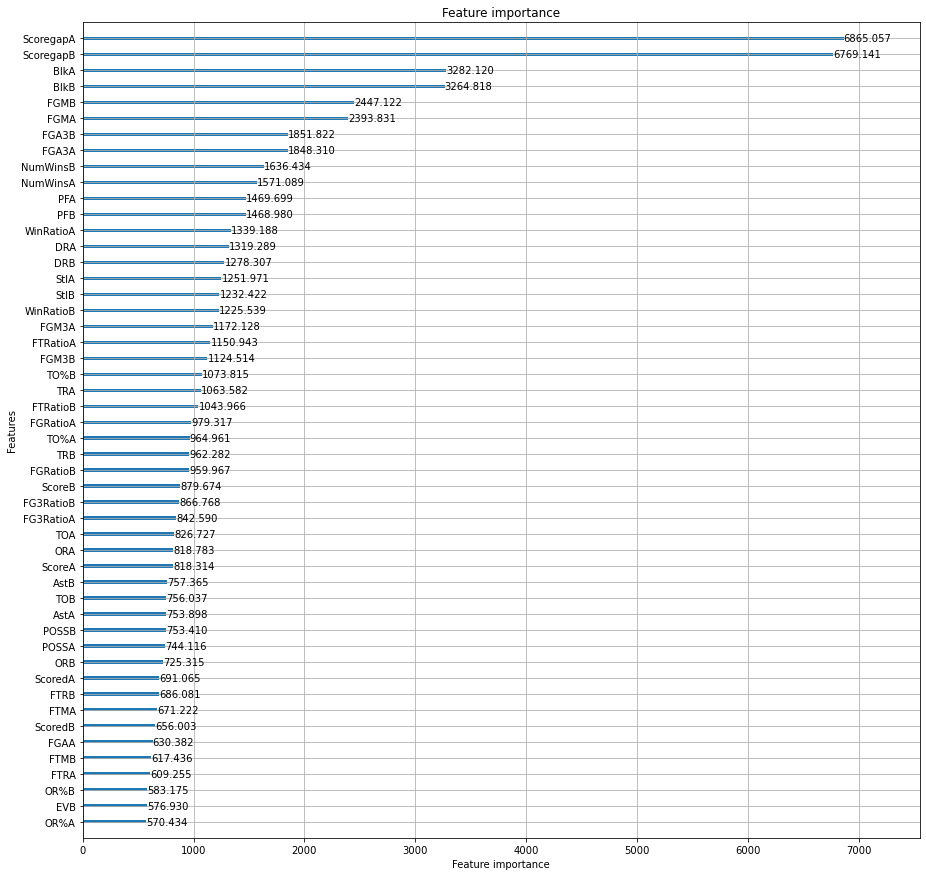

In [27]:
if TRAIN:
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show();

In [28]:
epochs = 1000
batch_size = 8
learning_rate = 0.001

y_test_nn = []
models_nn = []

tourney_results = tourney_results.fillna(tourney_results.mean())
test = test.fillna(test.mean())

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=SEED)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    if TRAIN:
        nn_model = create_mlp(len(features), 1, learning_rate)
        nn_model.fit(x_train,y_train,
                     epochs=epochs,
                     validation_data=(x_val,y_val),
                     batch_size=batch_size,
                     callbacks=[EarlyStopping('val_loss',patience=10,mode='min',restore_best_weights=True)]
                    )
        
        #models_nn.append(nn_model)
        #nn_model.save_weights('./model_fold{}.hdf5'.format(k))
        y_pred_test_nn = nn_model.predict(test[features])
        y_test_nn.append(y_pred_test_nn)

        K.clear_session()

valid_season2015
Epoch 1/1000
142/142 [==============================] - 1s 9ms/step - loss: 0.7148 - AUC: 0.6065 - val_loss: 0.7507 - val_AUC: 0.6007
Epoch 2/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.6554 - AUC: 0.6697 - val_loss: 0.5967 - val_AUC: 0.7721
Epoch 3/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.6140 - AUC: 0.7228 - val_loss: 0.5649 - val_AUC: 0.8162
Epoch 4/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.6241 - AUC: 0.7133 - val_loss: 0.5526 - val_AUC: 0.8238
Epoch 5/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.6127 - AUC: 0.7337 - val_loss: 0.5381 - val_AUC: 0.8353
Epoch 6/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.5957 - AUC: 0.7530 - val_loss: 0.5267 - val_AUC: 0.8463
Epoch 7/1000
142/142 [==============================] - 1s 4ms/step - loss: 0.5900 - AUC: 0.7612 - val_loss: 0.5188 - val_AUC: 0.8474
Epoch 8/1000
142/142 [=======================

## Inference

In [29]:
# submission
y_test_sub =  np.mean(y_test,axis=0)
y_test_nn_sub =  np.mean(y_test_nn,axis=0)

sub = pd.read_csv(SUB_PATH)
sub["Pred"] = 0.5*y_test_sub +0.5*y_test_nn_sub
#sub["Pred"] = y_test_sub

sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [30]:
#check
print(y_test)
print(y_test_sub.shape)
print(y_test_nn)
print(y_test_nn_sub.shape)

[array([0.44773977, 0.27516544, 0.09262849, ..., 0.48575612, 0.85612291,
       0.91900748]), array([0.41138677, 0.4584653 , 0.292226  , ..., 0.47919393, 0.6468448 ,
       0.66495913]), array([0.37562032, 0.45230104, 0.16921575, ..., 0.51803108, 0.70129907,
       0.80597806]), array([0.39253979, 0.35003801, 0.13994441, ..., 0.35427318, 0.68149058,
       0.90734456]), array([0.25489462, 0.38185391, 0.03554139, ..., 0.26327228, 0.88925877,
       0.97539009])]
(2016,)
[array([[0.5139028 ],
       [0.36128414],
       [0.16812211],
       ...,
       [0.33990103],
       [0.91657734],
       [0.8793151 ]], dtype=float32), array([[0.5100068 ],
       [0.4404352 ],
       [0.12044773],
       ...,
       [0.47519636],
       [0.7593615 ],
       [0.8127535 ]], dtype=float32), array([[0.4657017 ],
       [0.34102902],
       [0.12229714],
       ...,
       [0.44115114],
       [0.75472   ],
       [0.7383616 ]], dtype=float32), array([[0.52299416],
       [0.41595125],
       [0.07771835

In [31]:
pd.DataFrame(y_test_nn[0]).isnull().sum()

0    0
dtype: int64

In [32]:
test[features].isnull().sum()

ScoreA        0
ScoredA       0
FGMA          0
FGAA          0
FGM3A         0
             ..
POSSB         0
PPPB          0
NumWinsB      0
NumLossesB    0
WinRatioB     0
Length: 62, dtype: int64